<a href="https://colab.research.google.com/github/Muun-Muun/clusterd_sattelites_optimization/blob/main/CA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

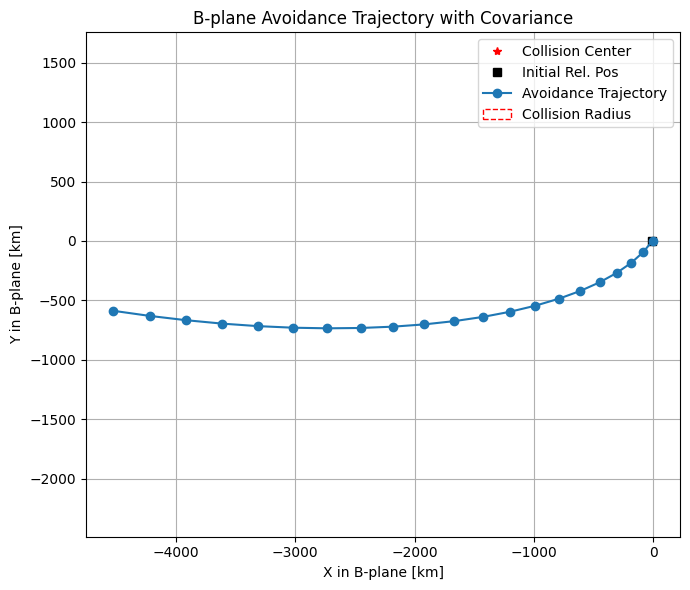

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cvxpy as cp

# 초기 상대 위치/속도 (ECI 차이)
r_rel = np.array([-3.8775302, 1.839096, -1.637136])
v_rel = np.array([-7.748925325, -9.527159675, 7.6451696])
x0 = np.concatenate([r_rel, v_rel])

# B-plane basis
def normalize(v): return v / np.linalg.norm(v)
z_hat = normalize(v_rel)
y_hat = normalize(np.cross(r_rel, v_rel))
x_hat = np.cross(y_hat, z_hat)
T = np.vstack([x_hat, y_hat, z_hat])
r_b = T @ r_rel

# 공분산 → B-plane 투영
cov1 = np.array([[44.57575448, 81.67517511, -67.86876627],
                 [81.67517511, 158.45340296, -128.61692164],
                 [-67.86876627, -128.61692164, 105.49054256]])
cov2 = np.array([[2.31067078, 1.69905294, -1.41701646],
                 [1.69905294, 1.24957388, -1.04174164],
                 [-1.41701646, -1.04174164, 0.86926056]])
cov_sum = cov1 + cov2
cov_b = T @ cov_sum @ T.T
cov2d = cov_b[:2, :2]
inv_cov = np.linalg.inv(cov2d)

# 설정
N = 20
dt = 10.0
n = 0.0011
alpha = 1e4
rc = 0.01

# CW dynamics
A = np.eye(6)
A[:3, 3:] = dt * np.eye(3)
A[3, 0] = 3 * n**2 * dt
A[3, 4] = 2 * n * dt
A[4, 3] = -2 * n * dt
A[5, 2] = -n**2 * dt
B = np.zeros((6, 3))
B[3:, :] = dt * np.eye(3)

# 최적화
x = cp.Variable((6, N+1))
u = cp.Variable((3, N))
constraints = [x[:, 0] == x0]
for k in range(N):
    constraints += [x[:, k+1] == A @ x[:, k] + B @ u[:, k]]
    constraints += [cp.norm(u[:, k], 2) <= 5e-4]

final_r = x[0:2, N]
objective = cp.Minimize(cp.sum(cp.norm(u, axis=0)) + alpha * cp.quad_form(final_r, inv_cov))
cp.Problem(objective, constraints).solve()

# 궤적 시각화
path = x.value[0:2, :]
vals, vecs = np.linalg.eigh(cov2d)
angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
width, height = 2 * np.sqrt(vals)

plt.figure(figsize=(7,6))
plt.plot(0, 0, 'r*', label='Collision Center')
plt.plot(r_b[0], r_b[1], 'ks', label='Initial Rel. Pos')
plt.plot(path[0], path[1], 'o-', label='Avoidance Trajectory')
# plt.gca().add_patch(Ellipse(r_b, width, height, angle, edgecolor='blue', facecolor='none', label='1-sigma Ellipse'))
plt.gca().add_patch(plt.Circle((0, 0), rc, color='red', fill=False, linestyle='--', label='Collision Radius'))

plt.xlabel('X in B-plane [km]')
plt.ylabel('Y in B-plane [km]')
plt.title('B-plane Avoidance Trajectory with Covariance')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


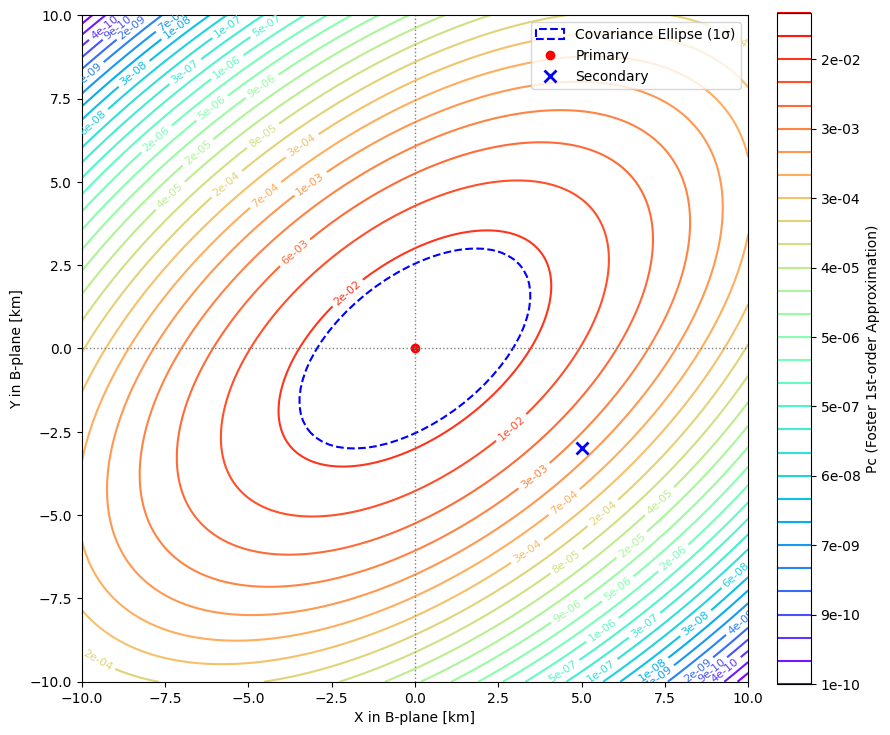

In [ ]:
# ✅ Foster 1차 근사 기반 충돌확률 Pc 시각화: 전체 코드

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

# ------------------------------
# 1. 설정값
# ------------------------------
HBR_val = 1.0  # Hard Body Radius
r_secondary_far = np.array([5.0, -3.0])  # 상대 위성 위치 (Secondary)
C = np.array([[12.0, 5.5], [5.5, 9.0]])  # 결합 공분산 행렬
C_inv = np.linalg.inv(C)

# ------------------------------
# 2. 공분산 기반 시각화 요소
# ------------------------------
eigvals, eigvecs = np.linalg.eigh(C)
angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
width, height = 2 * np.sqrt(eigvals)
sigma_x = np.sqrt(C[0, 0])
sigma_y = np.sqrt(C[1, 1])

# ------------------------------
# 3. 격자 생성
# ------------------------------
x_vals = np.linspace(-10, 10, 400)
z_vals = np.linspace(-10, 10, 400)
X, Z = np.meshgrid(x_vals, z_vals)

# ------------------------------
# 4. 마할라노비스 거리 제곱 및 1차 근사식
# ------------------------------
d2_grid = np.einsum('...i,ij,...j->...', np.dstack((X, Z)), C_inv, np.dstack((X, Z)))
pre_factor = HBR_val / (2 * sigma_x * sigma_y)
Pc_foster_1st = pre_factor * np.exp(-0.5 * d2_grid)

# ------------------------------
# 5. 플롯
# ------------------------------
fig, ax = plt.subplots(figsize=(9, 9))
levels = np.logspace(-10, -1, num=30)
contour = ax.contour(X, Z, Pc_foster_1st, levels=levels, cmap='rainbow', norm=LogNorm())
ax.clabel(contour, inline=True, fmt=lambda v: f"{v:.0e}", fontsize=8)

# 공분산 타원
cov_ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                      edgecolor='blue', linestyle='--', lw=1.5, fc='none', label='Covariance Ellipse (1σ)')
ax.add_patch(cov_ellipse)

# 위치 표시
ax.plot(0, 0, 'ro', label='Primary')
ax.plot(*r_secondary_far, 'bx', markersize=8, markeredgewidth=2, label='Secondary')
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axvline(0, color='gray', linestyle=':', linewidth=1)

# 레이아웃
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_xlabel('X in B-plane [km]')
ax.set_ylabel('Y in B-plane [km]')
ax.set_aspect('equal')
ax.legend(loc='upper right')

# 컬러바
cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04, format='%.0e')
cbar.set_label('Pc (Foster 1st-order Approximation)')
plt.tight_layout()
plt.show()


# OCP




In [ ]:
import numpy as np
import cvxpy as cp


## Functions

In [12]:
# 위성 운동 방정식
def two_body_ode(t, state):
    r = state[:3]
    v = state[3:]
    norm_r = np.linalg.norm(r)
    a = -mu * r / norm_r**3
    return np.hstack((v, a))

# 지구 시각화 함수
def draw_earth(ax, radius=6378.1, color='lightblue', alpha=0.5):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, alpha=alpha, edgecolor='none')

def rotation_matrix(raan, inc, theta):
    R3_raan = np.array([
        [np.cos(raan), -np.sin(raan), 0],
        [np.sin(raan),  np.cos(raan), 0],
        [0,             0,            1]
    ])
    R1_inc = np.array([
        [1, 0, 0],
        [0, np.cos(inc), -np.sin(inc)],
        [0, np.sin(inc),  np.cos(inc)]
    ])
    R3_theta = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])
    return R3_raan @ R1_inc @ R3_theta


## Initialization

In [5]:
# 기준 단위 및 설정
RE = 6378.1
g = 9.80665e-3
T_unit = np.sqrt(RE / g)
N = 200
T_total = 2000.0  # [s]
dt_real = T_total / N
dt = dt_real / T_unit
n = 0.0011 * T_unit
u_max = 5e-4 / g
Pc_max = 1e-4
rc_km = 0.01
rc = rc_km / RE


# CW dynamics 행렬 설정
A = np.eye(6)
A[:3, 3:] = dt * np.eye(3)
A[3, 0] = 3 * n**2 * dt
A[3, 4] = 2 * n * dt
A[4, 3] = -2 * n * dt
A[5, 2] = -n**2 * dt
B = np.zeros((6, 3))
B[3:, :] = dt * np.eye(3)


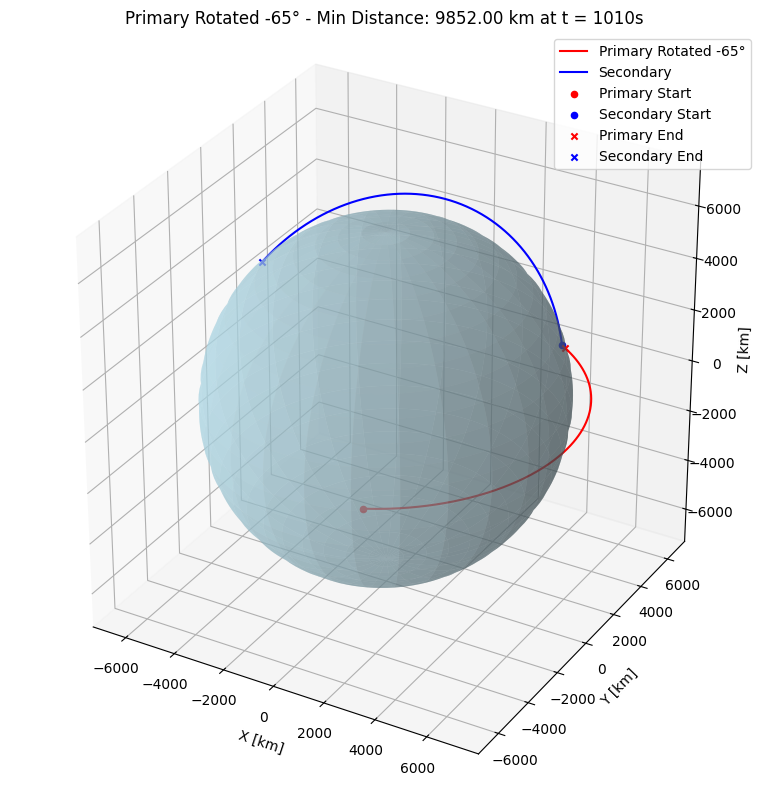

In [10]:
######### 시나리오 설정 #########
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 지구 중심 중력 상수
mu = 398600.4418  # km^3/s^2

# 궤도 파라미터 설정
r_mag = 7000.0
v_mag = np.sqrt(mu / r_mag)
T_total = 2000.0
N = 200
t_eval = np.linspace(0, T_total, N+1)
t_span = (0, T_total)

# Primary 위상각 -65도 회전
theta_primary = np.radians(-65)
R3_theta = np.array([
    [np.cos(theta_primary), -np.sin(theta_primary), 0],
    [np.sin(theta_primary),  np.cos(theta_primary), 0],
    [0,                      0,                     1]
])
r1_init = R3_theta @ np.array([r_mag, 0.0, 0.0])
v1_init = R3_theta @ np.array([0.0, v_mag, 0.0])

# Secondary: 경사 75도, RAAN 60도
theta = np.radians(90)
inc = np.radians(75)
raan = np.radians(60)

R_total = rotation_matrix(raan, inc, 0)
r2_init = R_total @ np.array([r_mag, 0.0, 0.0])
v2_init = R_total @ np.array([0.0, v_mag, 0.0])

# 수치 적분
sol1 = solve_ivp(two_body_ode, t_span, np.hstack((r1_init, v1_init)), t_eval=t_eval, rtol=1e-9, atol=1e-9)
sol2 = solve_ivp(two_body_ode, t_span, np.hstack((r2_init, v2_init)), t_eval=t_eval, rtol=1e-9, atol=1e-9)
r1_orbit = sol1.y[:3]
r2_orbit = sol2.y[:3]

# 최소 거리 및 시점
relative_distance = np.linalg.norm(r2_orbit - r1_orbit, axis=0)
min_distance = np.min(relative_distance)
t_min_dist = t_eval[np.argmin(relative_distance)]

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(r1_orbit[0], r1_orbit[1], r1_orbit[2], 'r-', label='Primary Rotated -65°')
ax.plot(r2_orbit[0], r2_orbit[1], r2_orbit[2], 'b-', label='Secondary')
ax.scatter(*r1_orbit[:, 0], color='r', marker='o', label='Primary Start')
ax.scatter(*r2_orbit[:, 0], color='b', marker='o', label='Secondary Start')
ax.scatter(*r1_orbit[:, -1], color='r', marker='x', label='Primary End')
ax.scatter(*r2_orbit[:, -1], color='b', marker='x', label='Secondary End')
draw_earth(ax)

ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.set_title(f'Primary Rotated -65° - Min Distance: {min_distance:.2f} km at t = {t_min_dist:.0f}s')
ax.set_box_aspect([1, 1, 1])
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# TCA 기준 상대 상태 벡터 (CW 기준, 무차원)
x0 = np.array([ 1.087, 0.939, 0.568, 0.490, 0.427, -1.652])

# 공분산 무차원화 및 B-plane 투영
cov1 = np.array([[44.57575448, 81.67517511, -67.86876627],
                 [81.67517511, 158.45340296, -128.61692164],
                 [-67.86876627, -128.61692164, 105.49054256]]) / RE**2
cov2 = np.array([[2.31067078, 1.69905294, -1.41701646],
                 [1.69905294, 1.24957388, -1.04174164],
                 [-1.41701646, -1.04174164, 0.86926056]]) / RE**2
cov_bplane = cov1 + cov2

# T_B: CW 기준 좌표계의 3x3 단위 행렬 (기본 설정)
T_B = np.eye(3)
cov_bplane = T_B @ cov_bplane @ T_B.T
cov2d = cov_bplane[:2, :2]
inv_cov2d = np.linalg.inv(cov2d)
det_Sigma = np.linalg.det(cov2d)


# delta 계산 (Foster 기반)
delta = -2 * np.log(Pc_max * np.sqrt(det_Sigma) / rc**2)


In [6]:
# 초기 guess (u=0)
x_guess = np.zeros((6, N+1))
x_guess[:, 0] = x0
for t in range(N):
    x_guess[:, t+1] = A @ x_guess[:, t]


# SCP 반복
max_iter = 10
eps_trust = 1e-2
for k in range(max_iter):
    x = cp.Variable((6, N+1))
    u = cp.Variable((3, N))
    constraints = [x[:, 0] == x0]

    for t in range(N):
        constraints += [x[:, t+1] == A @ x[:, t] + B @ u[:, t]]
        constraints += [cp.norm(u[:, t], 2) <= u_max]

    # Trust Region
    for t in range(N+1):
        constraints += [cp.norm(x[:, t] - x_guess[:, t], 2) <= eps_trust]

    # Mahalanobis 거리 제약 (rB 투영 적용)
    rB_k = T_B[:2, :] @ x_guess[0:3, -1]
    grad = 2 * inv_cov2d @ rB_k
    f_val = rB_k.T @ inv_cov2d @ rB_k
    rB_expr = T_B[:2, :] @ x[0:3, N]
    # constraints += [grad @ rB_expr >= delta - f_val + grad @ rB_k]

    prob = cp.Problem(cp.Minimize(cp.sum(cp.norm(u, axis=0))), constraints)
    prob.solve(solver=cp.SCS)

    print(prob.status)

    # if prob.status != cp.OPTIMAL:
    #     print("Infeasible at iteration", k)
    #     break
    # if np.linalg.norm(x.value - x_guess) < 1e-4:
    #     print("Converged at iteration", k)
    #     break

    x_guess = x.value

x_scp = x.value
u_scp = u.value